In [2]:
# standard library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# local classes
os.chdir('../')
from TraversalDistance.Graph import Graph
from TraversalDistance.FreeSpaceGraph import FreeSpaceGraph
from TraversalDistance.Visualize import Visualize
from TraversalDistance.BinarySearch import BinarySearch
os.chdir('leaf_data')

In [3]:
df = pd.read_csv('maracuya.csv')

In [4]:
df = df.drop(columns=['plant', 'heteroblasty', 'ontogeny', 'total'])

In [5]:
# divide species into seven classes based on the paper
# https://academic.oup.com/gigascience/article/6/1/giw008/2865207?login=true#supplementary-data
species_classes = {'miniata':6,
    'amethystina':3,
    'alata':5,
    'rubra':1,
    'misera':0,
    'setacea':2,
    'triloba':4,
    'nitida':5,
    'actinia':4,
    'villosa':5,
    'micropetala':1,
    'mucronata':6,
    'maliformis':6,
    'miersii':4,
    'malacophylla':6,
    'gibertii':2,
    'mollissima':2,
    'caerulea':2,
    'gracilis':3,
    'foetida':3,
    'racemosa':5,
    'tenuifila':2,
    'cristalina':6,
    'ligularis':5,
    'cincinnata':2,
    'coccinea':6,
    'hatschbachii':2,
    'morifolia':3,
    'organensis':1,
    'capsularis':1,
    'edmundoi':2,
    'galbana':6,
    'tricuspis':1,
    'pohlii':1,
    'biflora':1,
    'sidifolia':4,
    'suberosa':2,
    'edulis':5,
    'coriacea':0,
    'kermesina':2}

# replace species names with class in dataset
df['species_classes'] = df['species'].map(species_classes)


In [6]:
df.head(10)

,species,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,y11,x12,y12,x13,y13,x14,y14,x15,y15,species_classes
0,actinia,1.939415,414.812913,-7.047279,385.719915,28.429685,371.115922,65.726986,378.318652,99.227324,...,-1510.662028,563.252807,-424.176777,570.669793,-326.497673,405.345149,249.386171,381.749535,279.209462,4
1,actinia,-27.972095,433.154746,-27.127051,417.953521,-17.138482,393.213241,21.438983,394.733759,42.800256,...,-1468.443026,525.022693,-425.378430,538.426886,-343.900676,489.936964,124.340189,467.627131,173.870135,4
2,actinia,-43.242816,430.053913,-39.277936,409.976781,-34.239161,376.468073,4.770596,377.631881,19.758407,...,-1462.301694,546.694706,-517.910591,557.727421,-406.283139,488.911001,155.339518,460.348932,210.137903,4
3,actinia,-36.082509,416.832663,-30.527203,394.236217,-19.829324,359.869763,13.246641,361.064598,25.471213,...,-1385.313503,535.019483,-519.980964,617.977373,-346.868643,517.511348,207.452944,483.026127,261.141674,4
4,actinia,-7.724386,362.852233,-18.024917,347.266408,-16.965580,316.096657,18.166718,313.986527,26.485501,...,-1493.947554,572.248040,-473.575088,591.964194,-391.158971,440.811250,275.545461,392.206108,308.648330,4
5,actinia,-16.055860,392.188151,-19.701117,368.256849,-9.515832,342.898888,27.067663,356.380453,37.014086,...,-1424.586489,583.337495,-406.982599,603.598228,-307.765333,556.231575,146.518317,536.364320,211.098302,4
6,actinia,-34.824296,373.196015,-37.809982,356.192512,-36.947907,316.275227,13.351338,310.079425,15.471099,...,-1459.041832,617.465742,-398.390383,641.548306,-285.920461,500.624211,191.235877,465.752611,237.127426,4
7,actinia,-0.098964,362.559497,-3.733424,339.677463,0.430087,311.153987,45.967204,320.472914,61.537506,...,-1413.747737,644.222662,-358.288967,681.068810,-276.978490,504.490160,210.448210,449.125344,259.963456,4
8,actinia,15.427561,361.231239,2.307194,343.790835,8.969152,315.380138,54.676368,305.552733,71.741267,...,-1418.757910,632.358628,-445.899448,658.847353,-352.526786,455.654742,263.676606,394.493425,306.790393,4
9,actinia,-15.812526,408.515549,-20.146761,392.283320,-13.664190,358.731703,27.468388,381.445451,38.299236,...,-1260.294638,584.556000,-442.321698,619.207411,-381.727365,606.390413,142.082100,558.795625,215.690020,4


In [7]:
# edges to build graph
edges = {(1, 2),
    (2, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (6, 1),
    (1, 7),
    (2, 7),
    (2, 9),
    (3, 9),
    (3, 11),
    (4, 11),
    (4, 13),
    (5, 13),
    (5, 15),
    (6, 15),
    (7, 8),
    (8, 9),
    (9, 10),
    (10, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (14, 15)
}

x_headers = [f'x{i}' for i in range(1, 16)]
y_headers = [f'y{i}' for i in range(1, 16)]

min_max_scale = lambda s: (s - s.min()) / (s.max() - s.min())

# function to convert observation into Graph object
def observation_to_graph(row):

    x_row, y_row = row[x_headers], row[y_headers]
        
    graph = Graph()
    graph.name = row['species']

    for i, (x_header, y_header) in enumerate(zip(x_headers, y_headers), 1):
        x, y = x_row[x_header], y_row[y_header]
        graph.addNode(i, x, y)
        
    for i, edge in enumerate(edges, 1):
        graph.connectTwoNodes(i, edge[0], edge[1])
            
    return graph

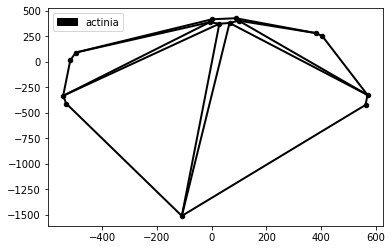

In [8]:
# First observation example. 
row_1 = df.iloc[0]
row_9 = df.iloc[7]
graph_1 = observation_to_graph(row_1)
graph_2 = observation_to_graph(row_9)

graph_1.Plot2MatPlotLib()

In [9]:
binary_search = BinarySearch(graph_1, graph_1, left=0, right=1000, precision=10)
binary_search.search()

7.8125

In [10]:
binary_search = BinarySearch(graph_2, graph_1, left=0, right=1000, precision=10)
binary_search.search()

460.9375

In [11]:
binary_search = BinarySearch(graph_1, graph_2, left=0, right=1000, precision=10)
epsilon = binary_search.search()

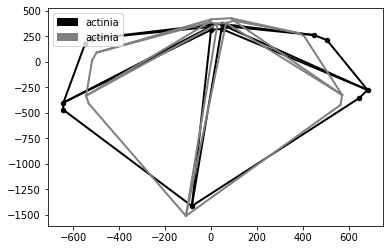

In [12]:
visual = Visualize(graph_2, graph_1, epsilon=epsilon)
visual.plot_graphs()

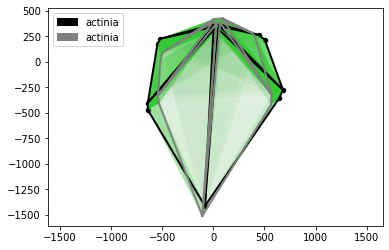

In [13]:
visual.plot_freespace()

In [16]:
fsg = FreeSpaceGraph(graph_2, graph_1, epsilon=500)
check = fsg.DFSTraversalDist()

print("\n-- Epsilon --")
print(f"     {fsg.epsilon}")

print("\n-- Sample Graphs --")
print(f"     No. edges in g1:", graph_1.numberOfEdges)
print(f"     No. vertices in g1:", graph_1.numberOfNodes)
print(f"     No. edges in g2:", graph_2.numberOfEdges)
print(f"     No. vertices in g2:", graph_2.numberOfNodes)

print("\n -- Running Traversal Distance --")
print("     DFS Function Calls:", fsg.DFS_calls)
print("     DFS FS CBs computed:", len(fsg.cell_boundaries))
print("     Total Possible CBs:", fsg.cb_count)
print("     Projection:", check)



-- Epsilon --
     500

-- Sample Graphs --
     No. edges in g1: 24
     No. vertices in g1: 15
     No. edges in g2: 24
     No. vertices in g2: 15

 -- Running Traversal Distance --
     DFS Function Calls: 2
     DFS FS CBs computed: 720
     Total Possible CBs: 720
     Projection: True


In [20]:
species_1 = df[df['species'] == 'actinia']
species_1.head()

,species,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,y11,x12,y12,x13,y13,x14,y14,x15,y15,species_classes
0,actinia,1.939415,414.812913,-7.047279,385.719915,28.429685,371.115922,65.726986,378.318652,99.227324,...,-1510.662028,563.252807,-424.176777,570.669793,-326.497673,405.345149,249.386171,381.749535,279.209462,4
1,actinia,-27.972095,433.154746,-27.127051,417.953521,-17.138482,393.213241,21.438983,394.733759,42.800256,...,-1468.443026,525.022693,-425.378430,538.426886,-343.900676,489.936964,124.340189,467.627131,173.870135,4
2,actinia,-43.242816,430.053913,-39.277936,409.976781,-34.239161,376.468073,4.770596,377.631881,19.758407,...,-1462.301694,546.694706,-517.910591,557.727421,-406.283139,488.911001,155.339518,460.348932,210.137903,4
3,actinia,-36.082509,416.832663,-30.527203,394.236217,-19.829324,359.869763,13.246641,361.064598,25.471213,...,-1385.313503,535.019483,-519.980964,617.977373,-346.868643,517.511348,207.452944,483.026127,261.141674,4
4,actinia,-7.724386,362.852233,-18.024917,347.266408,-16.965580,316.096657,18.166718,313.986527,26.485501,...,-1493.947554,572.248040,-473.575088,591.964194,-391.158971,440.811250,275.545461,392.206108,308.648330,4


In [21]:
graphs = list()
for index, row in species_1.iterrows():
    graph = observation_to_graph(row)
    graphs.append(graph)


In [22]:
sample_graph = graphs.pop()
search = lambda x: BinarySearch(x, sample_graph, left=0, right=1000, precision=10).search()
epsilons = list(map(search, graphs))

min index: 37 min value: 117.1875


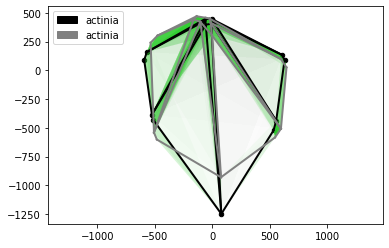

In [25]:
min_epsilon = min(epsilons)
index = epsilons.index(min_epsilon)
print("min index:", index, "min value:", min_epsilon)
visual = Visualize(graphs[index], sample_graph, epsilon=min_epsilon)
visual.plot_freespace()

max index: 0 max value: 296.875


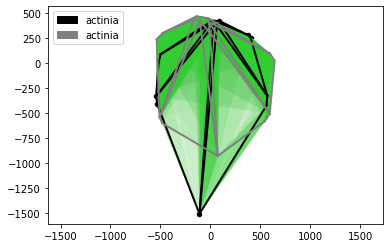

In [26]:
max_epsilon = max(epsilons)
index = epsilons.index(max_epsilon)
print("max index:", index, "max value:", max_epsilon)
visual = Visualize(graphs[index], sample_graph, epsilon=max_epsilon)
visual.plot_freespace()